## 650710736 อินทิรา ภู่ขำ

In [ ]:
# ขั้นตอนที่ 1 ติดตั้งไลบรารีที่จำเป็น

In [1]:
!pip install osmnx==1.9.1 folium -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.3/104.3 kB 1.9 MB/s eta 0:00:00


In [ ]:
# ขั้นตอนที่ 2 Import และตั้งค่าพื้นฐาน

In [2]:
import osmnx as ox
import networkx as nx
import folium
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display

In [3]:
ox.settings.use_cache = True
ox.settings.log_console = False

In [4]:
print(f"OSMnx version: {ox.__version__}")
print(f"NetworkX version: {nx.__version__}")

OSMnx version: 1.9.1
NetworkX version: 3.5


In [ ]:
# ขั้นตอนที่ 3 ดึงข้อมูลแผนที่กรุงเทพฯ

In [5]:
place_name = "Mueang Nakhon Pathom, NaKhon Pathom, Thailand"

- Nodes (intersections): 15,953
- Edges (street segments): 36,034


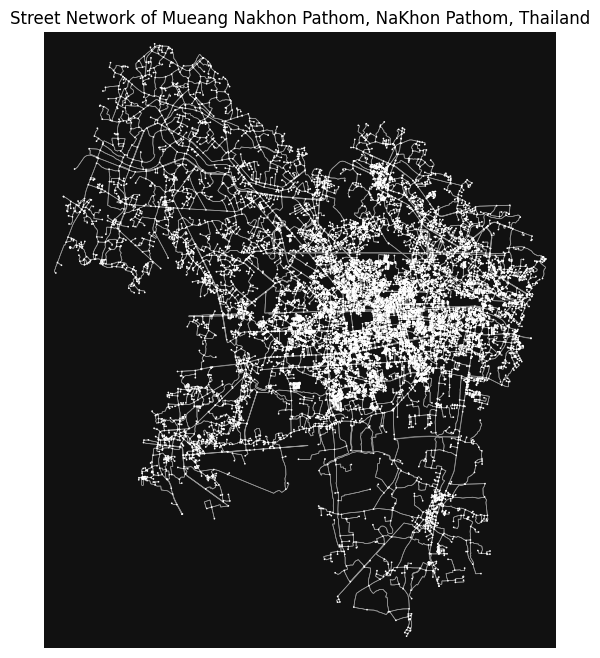

In [6]:
try:
    # ดึงข้อมูลเครือข่ายถนนสำหรับการขับรถ
    G = ox.graph_from_place(place_name, network_type='drive')

    print(f"- Nodes (intersections): {G.number_of_nodes():,}")
    print(f"- Edges (street segments): {G.number_of_edges():,}")

    fig, ax = ox.plot_graph(G, node_size=1.5, edge_linewidth=0.5, show=False, close=False)
    plt.title(f"Street Network of {place_name}")
    plt.show()

except Exception as e:
    print(f"Error downloading map data: {e}")

In [ ]:
# ขั้นตอนที่ 4 สำรวจข้อมูลเบื้องต้น

In [7]:
edges = ox.graph_to_gdfs(G, nodes=False)

print("🔍 Sample street data (first 5 streets):")
print(edges[['highway', 'length', 'name']].head())

print("\n📊 Types of roads in our graph:")
highway_counts = edges['highway'].value_counts()
print(highway_counts.head(10))

🔍 Sample street data (first 5 streets):
                               highway   length           name
u         v          key                                      
268631389 2286464669 0     residential   38.865            NaN
          2286437642 0         primary   42.632  ถนนเศรษฐกิจ 2
268631499 8508809475 0         primary  608.453  ถนนเศรษฐกิจ 2
          8366677988 0        tertiary   65.310            NaN
268631511 2902182791 0    primary_link   12.619            NaN

📊 Types of roads in our graph:
highway
residential      26256
unclassified      7171
tertiary          1490
primary            366
trunk              265
secondary          244
tertiary_link       65
trunk_link          63
primary_link        45
motorway_link       20
Name: count, dtype: int64


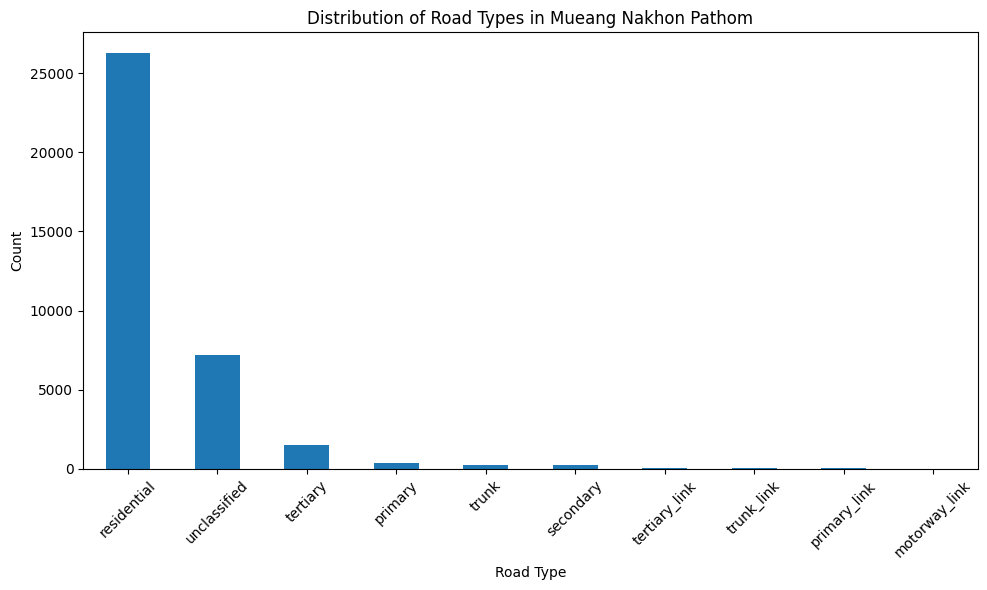

In [8]:
plt.figure(figsize=(10, 6))
highway_counts.head(10).plot(kind='bar')
plt.title("Distribution of Road Types in Mueang Nakhon Pathom")
plt.xlabel("Road Type")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
# ขั้นตอนที่ 5 กำหนดจุดเริ่มต้นและปลายทาง

In [9]:
start_lat, start_lon = 13.8127219, 100.0504930
start_name = "Ban Thai"

In [10]:
end_lat, end_lon = 13.8171288, 100.0420205
end_name = "Silpakorn University Sanam Chandra"

In [11]:
#  หาโหนดที่ใกล้ที่สุดบนกราฟ
orig_node = ox.nearest_nodes(G, start_lon, start_lat)
dest_node = ox.nearest_nodes(G, end_lon, end_lat)

print(f"🚶 Starting point: {start_name}")
print(f"   Node ID: {orig_node}")
print(f"🎯 Destination: {end_name}")
print(f"   Node ID: {dest_node}")

🚶 Starting point: Ban Thai
   Node ID: 1217513552
🎯 Destination: Silpakorn University Sanam Chandra
   Node ID: 1125952753


In [12]:
if nx.has_path(G, orig_node, dest_node):
    print("Path exists between origin and destination!")
else:
    print("No path found! Try different locations.")

Path exists between origin and destination!


In [ ]:
# ขั้นตอนที่ 6 หาเส้นทางที่สั้นที่สุดด้วย A*

In [13]:
try:
    # ใช้ A* algorithm หาเส้นทางที่สั้นที่สุด (ตามระยะทาง)
    shortest_route = nx.astar_path(G, orig_node, dest_node, weight='length')

    # คำนวณระยะทางรวม
    route_length = nx.path_weight(G, shortest_route, weight='length')

    print(f"✅ Shortest route found!")
    print(f"📏 Total distance: {route_length:,.0f} meters ({route_length/1000:.2f} km)")
    print(f"🔢 Number of intersections: {len(shortest_route)}")

except nx.NetworkXNoPath:
    print("❌ No path found between these locations!")
except Exception as e:
    print(f"❌ Error: {e}")

✅ Shortest route found!
📏 Total distance: 1,560 meters (1.56 km)
🔢 Number of intersections: 23


In [ ]:
# ขั้นตอนที่ 7 แสดงผลเส้นทางบนแผนที่ Interactive

In [14]:
route_map = ox.plot_route_folium(G, shortest_route,
                                  route_color='red',
                                  route_width=5,
                                  route_opacity=0.8)

/tmp/ipython-input-14-562654551.py:1: FutureWarning: The `folium` module has been deprecated and will be removed in the v2.0.0 release. You can generate and explore interactive web maps of graph nodes, edges, and/or routes automatically using GeoPandas.GeoDataFrame.explore instead, for example like: `ox.graph_to_gdfs(G, nodes=False).explore()`. See the OSMnx examples gallery for complete details and demonstrations.
  route_map = ox.plot_route_folium(G, shortest_route,


In [15]:
start_marker = folium.Marker(
    location=[start_lat, start_lon],
    popup=f"<b>Start:</b> {start_name}",
    icon=folium.Icon(color='green', icon='play')
)
start_marker.add_to(route_map)

end_marker = folium.Marker(
    location=[end_lat, end_lon],
    popup=f"<b>End:</b> {end_name}",
    icon=folium.Icon(color='red', icon='stop')
)
end_marker.add_to(route_map)

In [16]:
print("🗺️ Interactive map (zoom in/out to explore):")
display(route_map)

🗺️ Interactive map (zoom in/out to explore):


In [ ]:
# ขั้นตอนที่ 8 วิเคราะห์เส้นทาง

In [17]:
route_edges = ox.utils_graph.route_to_gdf(G, shortest_route, weight='length')

print("📊 Route Analysis:")
print(f"Total segments: {len(route_edges)}")
print(f"\n🛣️ Street names used:")

# รวบรวมชื่อถนนที่ใช้ (ไม่ซ้ำ)
street_names = route_edges['name'].dropna().unique()
for i, street in enumerate(street_names, 1):
    print(f"   {i}. {street}")

# แสดงประเภทถนนที่ใช้
print(f"\n🚗 Road types used:")
road_types = route_edges['highway'].value_counts()
for road_type, count in road_types.items():
    print(f"   - {road_type}: {count} segments")

📊 Route Analysis:
Total segments: 22

🛣️ Street names used:
   1. ถนน ราชมรรคา
   2. ถนนยิงเป้า
   3. ถนนทรงพล
   4. ถนนสนามจันทร์

🚗 Road types used:
   - tertiary: 13 segments
   - secondary: 7 segments
   - unclassified: 2 segments
